# Double Descent Phenomenon

Egy model kapacitásának növelése egy adott pontig csökkenti a teszt hibát, ezt követően a teszt hiba nő, majd az interpolációs küszöbön túl, a hiba ismét elkezd csökkenni.

[Schaeffer, Rylan, et al. (2023)](https://arxiv.org/abs/2303.14151)

[Belkin, Mikhail, et al. (2019)](https://arxiv.org/abs/1812.11118)

![alt](double_descent.png)

## Jelölés

$ \mathcal{D} = \{(x_1, y_1),...,(x_n,y_n)\},\ |\mathcal{D}| = N $

$ (x_i,y_i) \in \mathbb{R}^d \times \mathbb{R} $

$ f: \mathbb{R}^d \mapsto \mathbb{R} $ 

$ f \in \mathcal{H} $ függvény család

<!-- Van egy adathalmazunk ami alapján kiválasztunk egy h függvényt egy H függvénycsaládból amivel új adatok cimkéit tudjuk prediktálni -->

## Classical Bias-Variance trade-off

 1. Ha $\mathcal{H}$ kapacitása kicsi (_high bias_), akkor minden $ f \in \mathcal{H} $ nem illeszkedik megfelelő mértékben a tanulási adatokra (_under-fitting_), ezért új adatokra is rossz eredményeket fog adni.
 2. Ha $\mathcal{H}$ kapacitása nagy (_high variance_), akkor léteznek $ f \in \mathcal{H} $ amelyek tökéletesen illeszkednek a tanulási adatokra (_over-fitting_), viszont nem képesek általánosítani, ezért új adatokra rossz eredméyeket fognak adni.

Ezek alapján $\mathcal{H}$-t úgy kell kiválasztani, hogy a kapacitása a _sweet spot_-ban legyen


## "Modern" Interpolating Regime

![alt](modern.png)

Ha $ \mathcal{H} $ kapacitását növeljük, az interpolációs küszöbön túl <!-- Az a pont ahol létezik legalább 1 függvény H-ban amire a train hiba 0 -->, a tanulási hiba 0 marad, viszont a test hiba ismét elkezd csökkenni. Ez ellentmond a bias-variance trade-off elvnek.

__Egyszeűsített intuitív magyarázat.__ Az interpolációs küszöbön 1 függvény létezik, ami képes tökéletesen illeszkedni a tanulási adatokra, annak a valószínűsége, hogy ez a függvény új adatokra is illeszkedni fog eléggé alacsony. Az interpolációs küszöbön túl, több függvény fog tökéletesen illeszkedni az adatokra, tehát annak a valószínűsége, hogy létezik ezek között legalább egy olyan amely új adatokra is megfelő predikciókat ad, nagyobb.

<!-- Ez nem jelenti azt, hogy ez a függvény lesz valójában kiválasztva -->

### Vizuális Intuició Polinomiális Regresszióval

$ y: \mathcal{R} \mapsto \mathcal{R} $

$ y(x) = 2x + cos(25x) $

$ \phi_P: \mathcal{R} \mapsto \mathcal{R}^P $

$ \phi_P(x) = \left[ \begin{array}{c} \phi_1(x) \\ \phi_2(x) \\\vdots \\ \phi_P(x) \end{array} \right] $

$ y \approx \phi_P(x) \cdot \Theta_P $

<!-- Baloldalt: P < N a függvény under-fittel -->
<!-- Középen: P = N a függvény over-fittel -->
<!-- Jobb oldal P > N double descent -->

In [9]:
using Plots, Random, SpecialPolynomials, Statistics

In [84]:
N = 15
P = [1:25..., 30, 40, 50, 100]

f(x) = 2 .* x + cos.(x .* 25)
low = -1
high = 1

X_train = rand(N) .* (high - low) .+ low
Y_train = f(X_train)
X_test = collect(range(low, high, length=1000))
Y_test = f(X_test)
;

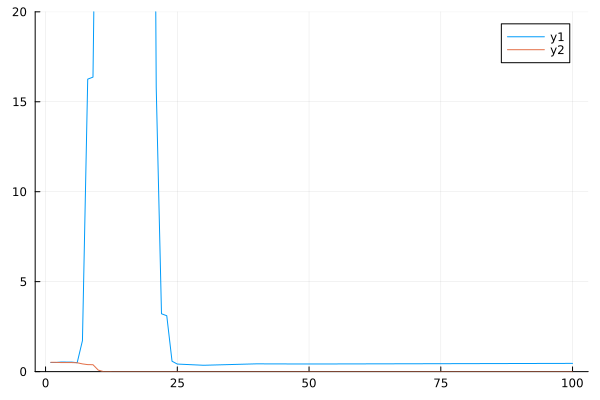

In [86]:
train_mse = []
test_mse = []
models = []

# Feature Function Factory
Φ(n) = (x) -> x .|> basis.(Legendre, 1:n)

model(Φ::Function, Θ::Vector{Float64}) = (x) -> Φ(x)' * Θ

mse(ground, pred) = mean((ground .- pred) .^ 2)

for p ∈ P
    Φₚ = Φ(p)
    X_train_features = reduce(hcat, Φₚ.(X_train))'
    X_test_features = reduce(hcat, Φₚ.(X_test))'
    Θ = X_train_features \ Y_train

    Y_train_pred = X_train_features * Θ
    Y_test_pred = X_test_features * Θ
    
    push!(models, model(Φₚ, Θ))
    push!(train_mse, mse(Y_train, Y_train_pred))
    push!(test_mse, mse(Y_test, Y_test_pred))
end

p = plot(P, test_mse, ylims=(0, 20))
plot(p, P, train_mse)

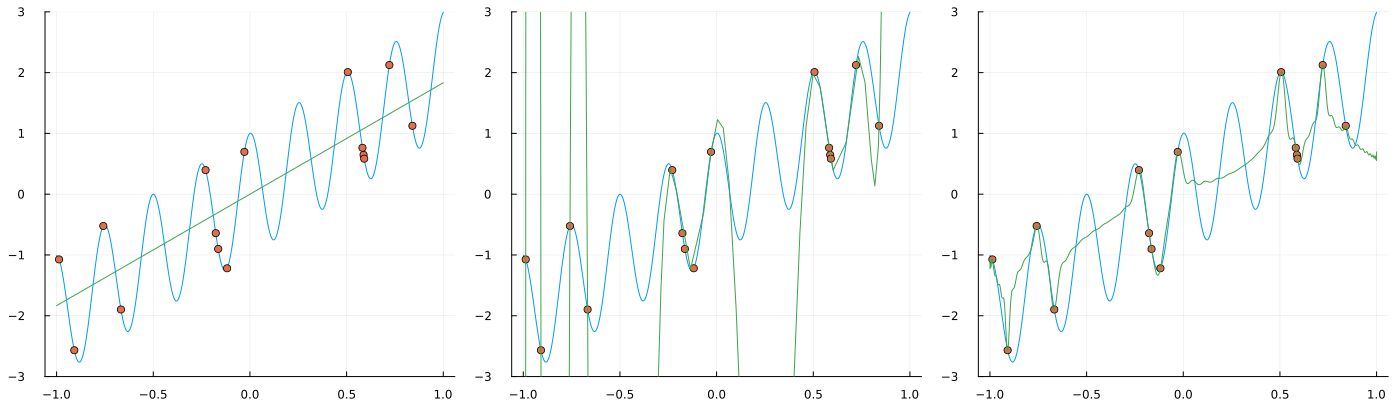

In [102]:
p = plot(X_test, Y_test, layout=(1,3), legends=false, size=(1400, 400))
plot!(p[2], X_test, Y_test, legends=false)
plot!(p[3], X_test, Y_test, legends=false)

scatter!(p[1], X_train, Y_train)
scatter!(p[2], X_train, Y_train)
scatter!(p[3], X_train, Y_train)

plot!(p[1], models[1], ylims=(-3, 3))
plot!(p[2], models[15], ylims=(-3, 3))
plot!(p[3], models[29], ylims=(-3, 3))

## Matematikai Intuició Lineáris Regresszióval

$ Y = X \cdot \Theta $

Lineáris regresszió esetében $ P = D $. Mivel a paraméterek száma nem növelhető, az adatok számát fogjuk csökkenteni.

 1. Ha $ P < N $

    $ \hat{\Theta}_{under} = arg \underset{\Theta}{min} || X \Theta - Y ||^2 $

    Megoldás: $ \hat{\Theta}_{under} = (X^TX)^{-1}X^TY $

 2. Ha $ P > N $

    $ \hat{\Theta}_{over} = arg \underset{\Theta}{min} || \Theta ||^2,\ \forall n \in \{1,...,N\}\ x_n \cdot \Theta = y_n $

    Megoldás: $ \hat{\Theta}_{over} = X^T(XX^T)^{-1}Y $

$ \hat{y}_{test,under} = x_{test} \cdot \hat{\Theta}_{under} = x_{test} \cdot (X^TX)^{-1}X^TY $

$ \hat{y}_{test,over} = x_{test} \cdot \hat{\Theta}_{over} = x_{test} \cdot X^T(XX^T)^{-1}Y $

Jelöljuk $ \Theta^* $-al az ismeretlen ideális paramétereket amikre minimális a teszt hiba

Tehát $ Y = X\Theta^* + E $, ahol $ E $ az adat megtanulhatatlan része

Ezt használva írjuk át a predikciót a két esetben

   1. P < N
   
      $ \hat{y}_{test,under} = x_{test} \cdot (X^TX)^{-1}X^TY $

      $ = x_{test} \cdot (X^TX)^{-1}X^T(X\Theta^* + E) $

      $ = x_{test} \cdot (X^TX)^{-1}X^TX\Theta^* + x_{test} \cdot (X^TX)^{-1}X^TE $

      $ = x_{test} \cdot \Theta^* + x_{test} \cdot (X^TX)^{-1}X^TE $

      $ x_{test} \cdot \Theta^* \overset{def}{=} y^*_{test} $

      $ \hat{y}_{test,under} - y^*_{test} = x_{test} \cdot (X^TX)^{-1}X^TE $

      $ (X^TX)^{-1}X^T = X^+ = V \Sigma^+ U^T$

      $ \hat{y}_{test,under} - y^*_{test} = x_{test} \cdot V \Sigma^+ U^TE = \sum_{r=1}^{R} { 1 \over \sigma_r } (x_{test} \cdot v_r)(u_r \cdot E) $

   2. P > N, a számítás hasonló (exercise for the reader)

      $ \hat{y}_{test,over} - y^*_{test} = \sum_{r=1}^{R} { 1 \over \sigma_r } (x_{test} \cdot v_r)(u_r \cdot E) + x_{test} \cdot (X^T(XX^T)^{-1}X-I_d)\Theta^* $

A két egyenlet arra mutat, hogy a teszt hibát 3 érték fog meghatározni:

   1. Mennyire változnak a tanulási adatok minden irányban: $  1 \over \sigma_r $
   2. Mennyire és milyen irányokban változnak a teszt adatok relatív a tanulási adatokhoz képest: $ x_{test} \cdot v_r $
   3. Mennyire képes az ideális modell megtanulni a tanulási adatokat: $ u_r \cdot E $

### Miért a legnagyobb a hiba az interpolációs küszöbön?

![alt](geometric.png)

### Mikor nem történik Double Descent?

 - Nincsenek nullához közeli szinguláris értékek $(\sigma_r)$
 - A teszt adatok nem változnak más irányokban mint a tanulási adatok
 - Az ideális model tökéletes illeszkedik a tanulási adathalmazra (E=0)